In [1]:
import sys,os,copy,glob,time
import numpy as np
sys.path.append(os.path.abspath('../../smodels'))
from smodels.tools.physicsUnits import fb
from smodels.tools import runtime
from smodels.tools import statistics
from smodels.tools.simplifiedLikelihoods import UpperLimitComputer, Data, LikelihoodComputer
runtime._experimental = True
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats,integrate,optimize,special

from smodels.experiment.databaseObj import Database
from tqdm.notebook import tqdm
from multiprocessing import Pool
import warnings
import shutil

runtime._cap_likelihoods = True
#sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=2.0)
sns.set_palette(sns.color_palette("Paired"))


In [2]:
def getSRs():
    from smodels.experiment.databaseObj import Database
    db = Database ( "official" )
    ers = db.getExpResults( dataTypes=[ "efficiencyMap" ] )
    stats_ = []
    for er in ers:
        for ds in er.datasets:
            D = { "obsN": ds.dataInfo.observedN, "expectedBG": ds.dataInfo.expectedBG,
                  "bgError": ds.dataInfo.bgError, "upperLimit": ds.dataInfo.upperLimit,
                  "expectedUpperLimit": ds.dataInfo.expectedUpperLimit }
            stats_.append ( D )
    return stats_

In [3]:
stats_ = getSRs()

In [4]:
def getNorm(func, args, b, getMulim=False):
    err = 1.
    ctr = 0
    b = 2*b
    norm = integrate.quad(func, 0 , b, args, epsabs=0.,epsrel=1e-3)[0]
    while err > 0.01:
        ctr+=1
        if ctr > 50.:
            raise Exception("Could not compute norm within required precision")
        norm_old = norm
        b = b*1.2
        norm = integrate.quad(func, 0, b, args, epsabs=0., epsrel=1e-3)[0]
        if norm == 0.:
            continue
        err = abs(norm_old-norm)/norm
    if getMulim:
        return norm, b
    return norm

In [5]:
# ### Compute observed and expected upper limits
def run ( nobs, nExp, nExpErr, nsig, plotname=False ):
    """ run the procedure, with:
    :param nobs: number of observed
    :param nExp: number expected
    :param nExpErr: error on number expected
    """
    print ( "Starting run with nobs", nobs, "nExp", nExp )
    data = Data ( nobs, nExp, nExpErr**2, nsignal = nsig)
    computer = UpperLimitComputer ( 10000 )
    marginalize = False #True
    ULobs = computer.ulSigma ( data, marginalize=marginalize )

    ULexp = computer.ulSigma ( data, expected=True, marginalize=marginalize )

    print(r'Nobs = %1.2f, Nbg = %1.2f +- %1.2f, Nsig < %1.2f, Nsig (expected) < %1.2f'
         %(nobs,nExp,nExpErr,ULobs,ULexp))

    nsteps = 100 # 100
    
    mulim = abs(nobs-nExp+4*nExpErr)
    Lmax = 1
    while Lmax > .01:
        Lmax = statistics.likelihoodFromLimits(ULobs, ULexp, mulim, underfluct="norm_0")
        mulim = 1.2 * mulim
    muvals = np.linspace(0, mulim, nsteps )
    
    smllhd = LikelihoodComputer(data)
    
    norm_gauss = getNorm(smllhd.marginalizedLLHD1D, args=(False), b=max(ULobs,ULexp))
    norm_loggauss = getNorm(smllhd.marginalizedLLHD1D, args=(False, "lognormal"), b=max(ULobs,ULexp))
    norm_profiled = getNorm(smllhd.profileLikelihood, args=(False), b=max(ULobs,ULexp))
    #norm_gauss = integrate.quad(smllhd.marginalizedLLHD1D, 0, mulim, args=(False))[0]
    #norm_loggauss = integrate.quad(smllhd.marginalizedLLHD1D, 0, mulim, args=(False, "lognormal"))[0]
    #norm_profiled = integrate.quad(smllhd.profileLikelihood, 0, mulim, args=(False))[0]
    
    llhds_app_norm0 = np.array([[mu, statistics.likelihoodFromLimits(ULobs, ULexp, mu, underfluct="norm_0")] for mu in muvals])
    llhds_app_norm_neg = np.array([[mu, statistics.likelihoodFromLimits(ULobs, ULexp, mu, underfluct="norm_neg")] for mu in muvals])
    llhds_app_exp = np.array([[mu, statistics.likelihoodFromLimits(ULobs, ULexp, mu, underfluct="exp")] for mu in muvals])
    llhds_full_norm = np.array([[mu, smllhd.marginalizedLLHD1D(mu, nll=False)/norm_gauss] for mu in muvals])
    llhds_full_lognorm = np.array([[mu, smllhd.marginalizedLLHD1D(mu, nll=False, bg_error="lognormal")/norm_loggauss] for mu in muvals])
    llhds_full_profiled = np.array([[mu, smllhd.profileLikelihood(mu, nll=False)/norm_profiled] for mu in muvals])
    
    f = plt.figure(figsize=(15,8))
    plt.plot(llhds_full_norm[:,0],llhds_full_norm[:,1],label='Smodels Full',linewidth=3, color="black")
    plt.plot(llhds_full_lognorm[:,0],llhds_full_lognorm[:,1],label='Smodels Full log',linewidth=3, color="blue")
    plt.plot(llhds_full_profiled[:,0],llhds_full_profiled[:,1],label='Smodels Full profiled',linewidth=3, color="brown")
    plt.plot(llhds_app_norm0[:,0],llhds_app_norm0[:,1],label='Gauss loc=0', linestyle='--', linewidth=3)
    plt.plot(llhds_app_exp[:,0],llhds_app_exp[:,1],label='Exp', linestyle='--', linewidth=3)
    plt.plot(llhds_app_norm_neg[:,0],llhds_app_norm_neg[:,1],label='Gauss loc<0', linestyle='--', linewidth=3)
    plt.legend()
    plt.xlabel(r'$\mu$')
    plt.ylabel(r'$L$')
    plt.title(r'$N_{obs} = %1.2f, N_{bg} = %1.2f \pm %1.2f, \sigma_{UL}^{obs} = %1.2f, \sigma_{UL}^{exp} = %1.2f, \Delta = %1.2f$'
              %(nobs,nExp,nExpErr,ULobs,ULexp,abs(ULobs-ULexp)/(ULobs+ULexp)),fontsize=14)
    if not plotname:
        plt.show()
        return
    
    plt.savefig("./plots/"+str(plotname))
    plt.close()
    


Starting run with nobs 9 nExp 11.8
Nobs = 9.00, Nbg = 11.80 +- 3.10, Nsig < 7.23, Nsig (expected) < 10.14


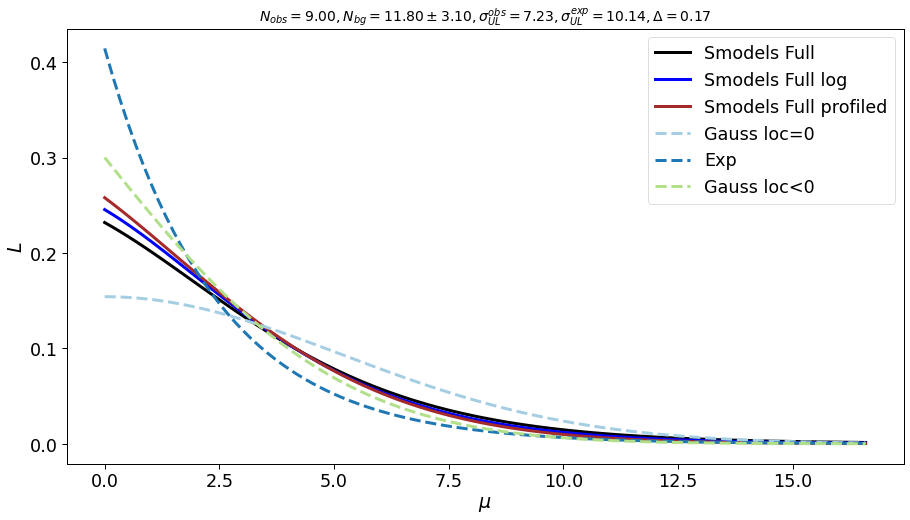

In [6]:
j = 10
t = run(int(stats_[j]["obsN"]), stats_[j]["expectedBG"], stats_[j]["bgError"], 1)

Starting run with nobs 11 nExp 4.2
Nobs = 11.00, Nbg = 4.20 +- 3.40, Nsig < 15.84, Nsig (expected) < 7.98


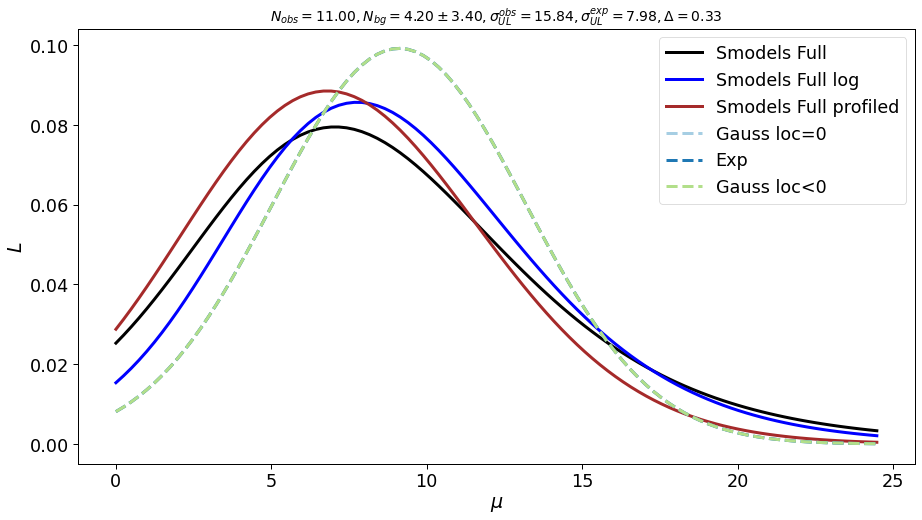

In [7]:
j = 44
run(int(stats_[j]["obsN"]), stats_[j]["expectedBG"], stats_[j]["bgError"], 1)

In [74]:
def num_moments(funct, mulim=np.inf):
    integrand_ev = lambda mu: mu*funct(mu)
    ev = integrate.quad(integrand_ev, 0., mulim, epsabs=0.,epsrel=1e-3)[0]
    
    integrand_var = lambda mu: (mu**2)*funct(mu)
    ev_x2 = integrate.quad(integrand_var, 0, mulim,epsabs=0.,epsrel=1e-3)[0]
    var = ev_x2 - ev**2
    
    integrand_skew = lambda mu: (mu**3)*funct(mu)
    ev_x3 = integrate.quad(integrand_skew, 0, mulim, epsabs=0.,epsrel=1e-3)[0]
    skew = ( ev_x3 - 3*ev*var - ev**3 ) / (var**(3/2))
    
    negllhd = lambda mu: -funct(mu)
    res = optimize.minimize(fun=negllhd, x0=ev, method="TNC", bounds=[(0.,np.inf)])
    mod = float(res["x"])
    
    return ({"ev":ev, "var":var, "skew":skew, "mode":mod})

In [75]:
# ### Compute observed and expected upper limits
def compare_methods ( nobs, nExp, nExpErr, nsig ):
    """ TODO:
    :param nobs: number of observed
    :param nExp: number expected
    :param nExpErr: error on number expected
    """
    data = Data ( nobs, nExp, nExpErr**2, nsignal = nsig)
    computer = UpperLimitComputer ( 10000 )
    marginalize = False #True
    ULobs = computer.ulSigma ( data, marginalize=marginalize )

    ULexp = computer.ulSigma ( data, expected=True, marginalize=marginalize )

    smllhd = LikelihoodComputer(data)
    
    res = {}
    
    modes_full = {"normal", "lognormal"}
    for mode in modes_full:
        norm, mulim = getNorm(smllhd.marginalizedLLHD1D, args=(False, mode), b=max(ULobs,ULexp), getMulim=True)
        llhd_full = lambda mu: smllhd.marginalizedLLHD1D(mu, nll=False, bg_error=mode)/norm
        #def llhd_full(mu): smllhd.marginalizedLLHD1D(mu, nll=False, bg_error=mode)/norm
        #    return smllhd.marginalizedLLHD1D(mu, nll=False, bg_error=mode)/norm
        res[mode] = num_moments(llhd_full, mulim)
    
    norm_profiled, mulim_profiled = getNorm(smllhd.profileLikelihood, args=(False), b=max(ULobs,ULexp), getMulim=True)
    llhd_profiled = lambda mu: smllhd.profileLikelihood(mu, nll=False)/norm_profiled
    #def llhd_profiled(mu):
    #    return smllhd.profileLikelihood(mu, nll=False)/norm_profiled
    res["profiled"] = num_moments(llhd_profiled, mulim_profiled)
    
    modes_app = ["norm_0", "norm_neg", "exp"]
    for mode in modes_app:
        res[mode] = statistics.llhdFromLimits_moments(ULobs, ULexp, underfluct=mode)
    
    #for mode in modes:
    #    def llhd_from_limits(mu):
    #        return statistics.likelihoodFromLimits(ULobs, ULexp, mu, underfluct=mode)
    #    result1 = num_moments(llhd_from_limits, np.inf)
    #    result2 = statistics.llhdFromLimits_moments(ULobs, ULexp, underfluct=mode)
    #    print(mode, result1, "\n", result2)

    
    return res   

Starting run with nobs 191 nExp 191
Nobs = 191.00, Nbg = 191.00 +- 21.00, Nsig < 49.67, Nsig (expected) < 49.67


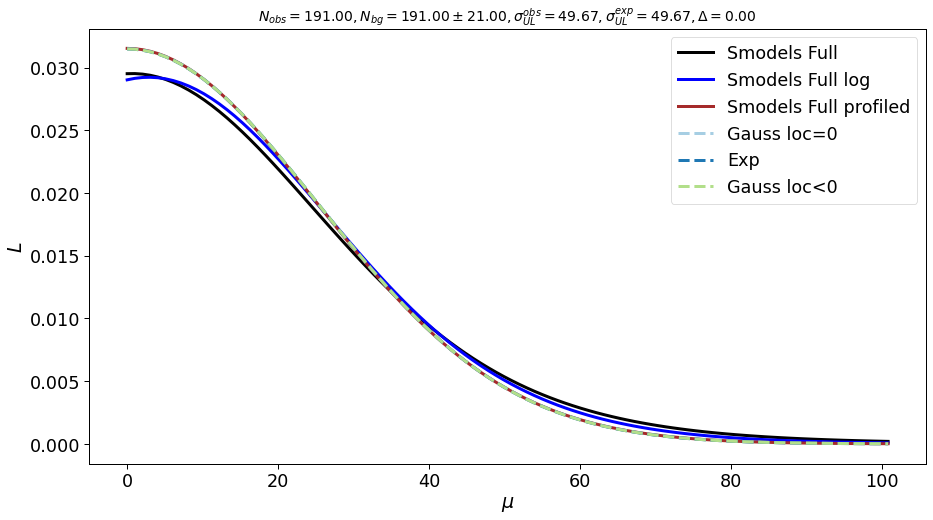

In [69]:
j = 4
run(int(stats_[j]["obsN"]), stats_[j]["expectedBG"], stats_[j]["bgError"], 1)

In [76]:
test = compare_methods (int(stats_[j]["obsN"]), stats_[j]["expectedBG"], stats_[j]["bgError"], 1)

In [77]:
test

{'lognormal': {'ev': 21.613867027150526,
  'var': 278.5567519689088,
  'skew': 1.1500159326974233,
  'mode': 2.8764560365663137},
 'normal': {'ev': 22.46438230179666,
  'var': 326.76312018856964,
  'skew': 1.2916566735438197,
  'mode': 0.6703891181420403},
 'profiled': {'ev': 20.24143344918587,
  'var': 235.1338324712313,
  'skew': 1.0063067288407204,
  'mode': 0.0},
 'norm_0': {'ev': 20.21911161373934,
  'var': 233.34469203801808,
  'skew': 0.9952514209081027,
  'mode': 0.0013855286232496503},
 'norm_neg': {'ev': 20.21911161373934,
  'var': 233.34469203801808,
  'skew': 0.9952514209081027,
  'mode': 0.0013855286232496503},
 'exp': {'ev': 20.21911161373934,
  'var': 233.34469203801808,
  'skew': 0.9952514209081027,
  'mode': 0.0013855286232496503}}

In [ ]:
llhds_meta =[]
for i in tqdm(range(len(stats_))):
    try:
        print(i)
        llhds_meta.append(compare_methods (int(stats_[i]["obsN"]), stats_[i]["expectedBG"], stats_[i]["bgError"], 1))
    except:
        print("Hiiiiier",i)

  0%|          | 0/271 [00:00<?, ?it/s]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249


WARNING in statistics.llhdFromLimits_moments() in 242: asking for likelihood from limit but difference between oUL(7.76) and eUL(2.92) is too large (dr=0.91>0.87). capping to 7.39.
WARNING in statistics.llhdFromLimits_moments() in 242: asking for likelihood from limit but difference between oUL(7.76) and eUL(2.92) is too large (dr=0.91>0.87). capping to 7.39.
WARNING in statistics.llhdFromLimits_moments() in 242: asking for likelihood from limit but difference between oUL(7.76) and eUL(2.92) is too large (dr=0.91>0.87). capping to 7.39.


250
251
252


In [68]:
llhds_meta[4]

{'lognormal': {'ev': 21.613867027150526,
  'var': 278.5567519689088,
  'skew': 1.1500159326974233,
  'mode': 21.613867027150526},
 'normal': {'ev': 22.46438230179666,
  'var': 326.76312018856964,
  'skew': 1.2916566735438197,
  'mode': 22.46438230179666},
 'profiled': {'ev': 20.24143344918587,
  'var': 235.1338324712313,
  'skew': 1.0063067288407204,
  'mode': 20.24143344918587},
 'norm_0': {'ev': 20.21911161373934,
  'var': 233.34469203801808,
  'skew': 0.9952514209081027,
  'mode': 0.0013855286232496503},
 'norm_neg': {'ev': 20.21911161373934,
  'var': 233.34469203801808,
  'skew': 0.9952514209081027,
  'mode': 0.0013855286232496503},
 'exp': {'ev': 20.21911161373934,
  'var': 233.34469203801808,
  'skew': 0.9952514209081027,
  'mode': 0.0013855286232496503}}

In [45]:
def reldiff(ex, app):
    if(ex < 0 or app < 0): return(warnings.warn("Negative Value encountered"))
    if(ex+app == 0): return(0)
    return(2*(ex-app) / (app+ex))

In [50]:
modes_full = ["normal", "lognormal", "profiled"]
modes_app = ["norm_0", "norm_neg", "exp"]
moments = ["ev", "var", "skew", "mode"]
reldiffs = []

for i in range(len(llhds_meta)):
    tempdict = {}
    for mode_f in modes_full:
        for mode_a in modes_app:
            for moment in moments:
                try:
                    ex = llhds_meta[i][mode_f][moment]
                    app = llhds_meta[i][mode_a][moment]
                    tempdict[mode_f+"_vs_"+mode_a+"_"+moment] = reldiff(ex, app)
                except:
                    print(i, mode_f, mode_a, moment)
    reldiffs.append(tempdict)
        

In [ ]:
def makehists():
    for mode_f in modes_full:
        for mode_a in modes_app:
            for moment in moments:
                fig = plt.figure(figsize=(10,7))
                plt.hist([reldiffs[x][mode_f+"_vs_"+mode_a+"_"+moment] for x in range(len(llhds_meta))])
                plt.title(mode_f+" vs "+mode_a+": "+moment)
                plt.savefig("./hists/"+mode_f+" vs "+mode_a+": "+moment))
                plt.close()

In [ ]:
if not os.path.exists("hists"):
    os.mkdir("hists")
    makehists()
else:
    new_plot = input('Would you like to redo the hists? (y/n)\n')
    if new_plot.lower() == 'yes' or new_plot.lower() == 'y':
        shutil.rmtree("hists")
        os.mkdir("hists")
        makehists()
    else:
        print("Aborting")

In [67]:
for i in range(len(reldiffs)):
    if reldiffs[i]["normal_vs_norm_0_mode"]>1.9:
        print(i)


3
4
7
24
31
37
41
42
43
45
46
47
48
54
55
65
69
78
86
88
89
91
96
99
108
111
112
116
123
127
128
133
137
140
144
146
147
149
155
158
159
161
164
165
166
167
169
170
171
173
174
176
178
179
181
183
188
199
201
203
204
205
214
216
222
223
241
243
245
247
248
251
252
255
264
268
270


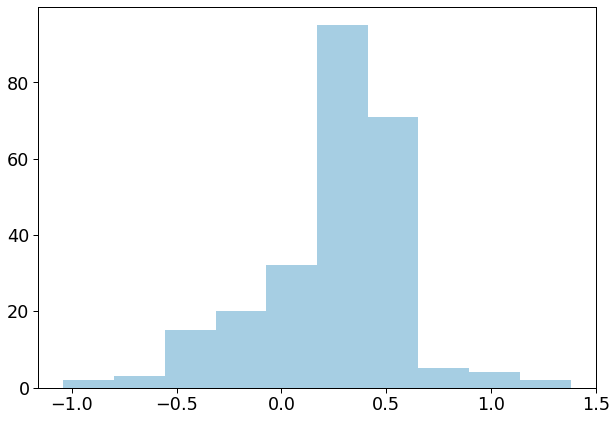

In [19]:
fig = plt.figure(figsize=(10,7))
plt.hist([reldiffs[x]["normal_vs_norm_0_var"] for x in range(249)])

plt.show()

In [20]:
if not os.path.exists("plots"):
    os.mkdir("plots")
    for i in tqdm(range(len(stats_))):
            run(int(stats_[i]["obsN"]), stats_[i]["expectedBG"], stats_[i]["bgError"], 1, plotname="llhds"+str(i)+".png")
else:
    new_plot = input('Would you like to redo the Plots? (y/n)\n')
    if new_plot.lower() == 'yes' or new_plot.lower() == 'y':
        shutil.rmtree("plots")
        os.mkdir("plots")
        for i in tqdm(range(len(stats_))):
            run(int(stats_[i]["obsN"]), stats_[i]["expectedBG"], stats_[i]["bgError"], 1, plotname="llhds"+str(i)+".png")
    else:
        print("Aborting")

Would you like to redo the Plots? (y/n)
n
Aborting


In [21]:
#def append_llhds_meta(i):
#    llhds_meta.append(compare_methods (int(stats_[i]["obsN"]), stats_[i]["expectedBG"], stats_[i]["bgError"], 1))

In [22]:
#llhds_meta = []
#pool = Pool()
#d = pool.map(append_llhds_meta, range(len(stats_)))